In [239]:
import pandas as pd 
import numpy as np 
import random
import plotly.express as px
from math import comb, pow
from sys import stdout
from matplotlib import pyplot as plt
import seaborn as sns

In [251]:
'''
Modelo de Ehrenfest

La cadena de ehrenfest fue desarrollado para modelar el intercambio de moleculas entre dos contenedores. 

En cada tiempo una molecula es seleccionada de manera aleatoria y se traspasa al otro contenedor.


Espacio de estados: {0, 1, ..., n}

'''


def move_ball(state: int, n:int) -> int:
    ''' 
    Mediante esta función calculamos el estado de nuestro modelo de ehrenfast en el siguiente tiempo.
    global:
        state
    '''
    threshold = state/n
    if random.random()>threshold:
        state += 1
    else:
        state -= 1
    return state

def zero_fill(distribution: dict, n: int):
    ''' Llena los valores faltantes con 0's'''
    for i in range(n+1):
        if not i in distribution:
            distribution[i] = 0
    return distribution

def value_convergence(distributions: dict, n:int):
    ''' Regresa un diccionario con la probabilidad simulada de cada estado.'''
    evolutions = {}
    for i in range(n+1):
        evolutions[i] = []
    for distribution in distributions:
        for i in distribution:
            evolutions[i].append(distribution[i])
    return evolutions
            
def plot_convergence(distributions:pd.Series):
    ''' Genera un plot con la convergencia de probabilidad de cada estado.'''
    if not isinstance(distributions, pd.Series):
        distributions = pd.Series(distributions)
    evolutions = value_convergence(distributions)
    px.line(evolutions)
    
def theoric_distribution(n:int):
    ''' Calculamos la distribución estacionaria de una cadena de Ehrenfest de n bolas.'''
    idx = []
    probabilities = []
    for i in range(n + 1):
        idx.append(i)
        probabilities.append(comb(n, i)*pow(1/2, n))
    return pd.Series(index = idx, data = probabilities)

def simulation_error(theoric:pd.Series, simulated_distribution:pd.Series) -> pd.Series:
    ''' Calcula los errores en entre una simulación y la distribución teorica de una cadena de Ehrenfast'''
    global distributions
    if not isinstance(simulated_distribution, pd.Series):
        simulated_distribution = pd.Series(simulated_distribution)
    return abs(theoric - simulated_distribution)

    
def calculate_errors(theoric_distribution: pd.Series, distributions:list, metric:str = 'mae') -> pd.Series:
    ''' Calcula el error medio de una simulación en cada iteración.'''
    if not metric.lower() in ['mae','mse']:
        raise ValueError(f'metric "{metric}" is not a valid metric.')
    errors = []
    for distribution in distributions:
        if metric == 'mae':
            errors.append(simulation_error(theoric_distribution, distribution).mean())
        else:
            errors.append((simulation_error(theoric_distribution, distribution)**2).mean())
    return pd.Series(errors)

def plot_errors(errors:pd.Series, metric:str):
    ''' Genera un plot de errores medios'''
    if not isinstance(errors, pd.Series):
        errors = pd.Series(errors)
    errors = errors[errors.index%10 == 0]
    return px.line(errors, title = f'{metric} error', labels = {'value':metric , 'index':'iterations'})


### A continuación comparamos la distribución simulada de una cadena Ehrenfast y la comparamos con su distribución teoríca.

### Sabemos que la distribución estacionaria del modelo de ehrenfest con $n$ bolas es
### $f(x) = {n \choose x}(\frac{1}{2})^n, x \in S$

In [263]:
def make_plot(fig, axes:np.array, states:list, distributions:pd.Series, n:int):
    '''Genera un graficos para analizar la simulación realizada.'''
    if axes.shape != (3,):
        raise TypeError(f'Invalid axes.')
    fig.suptitle(f'Analisis de simulación: Ehrenfast {n} bolas.')
    ## Grafica de distribución.
    axes[0].plot(theoric_distribution(n), color = 'red')
    axes[0].hist(states, rwidth = .95, density = True)
    axes[0].set_title('Distribución')
    ## Grafica de convergencia de valores.
    vc = value_convergence(distributions, n)
    for key in vc:
        axes[1].plot(vc[key])
    axes[1].legend(vc.keys())
    axes[1].set_title('Densidad de estados.')
    ## Grafica de convergencia de valores:
    errors = calculate_errors(theoric_distribution(n), distributions)
    axes[2].plot(errors)
    axes[2].set_ylim(bottom = 0)
    axes[2].set_title('Error medio absoluto')
    return axes
    


In [264]:
def main(n_experimentos, estado_inicial, n):
    # 1. Realizamos experimentos con parametros indicados.
    states = []     # lista para almacenar resultados
    state = estado_inicial
    states = np.zeros(n_experimentos + 1, dtype = int)
    states[0] = estado_inicial 
    distributions = []

    for i in range(n_experimentos):
        if i%500 == 0:
            stdout.write(f'{(i/n_experimentos)*100:.1f}%')
            stdout.flush()
            if i!=0:
                stdout.write('\r')
        state = move_ball(state, n)
        states[i+1] = state
        
        vals, counts = np.unique(states[0:i+1], return_counts = True)
        counts = counts/counts.sum()
        
        t_distribution = {}
        for j in range(len(counts)):
            t_distribution[vals[j]] = counts[j]
        t_distribution = zero_fill(t_distribution, n)
        distributions.append(t_distribution)
    
    fig, axes = plt.subplots(3,1, figsize = (25, 15))
    axes = make_plot(fig, axes, states, distributions, n)
    





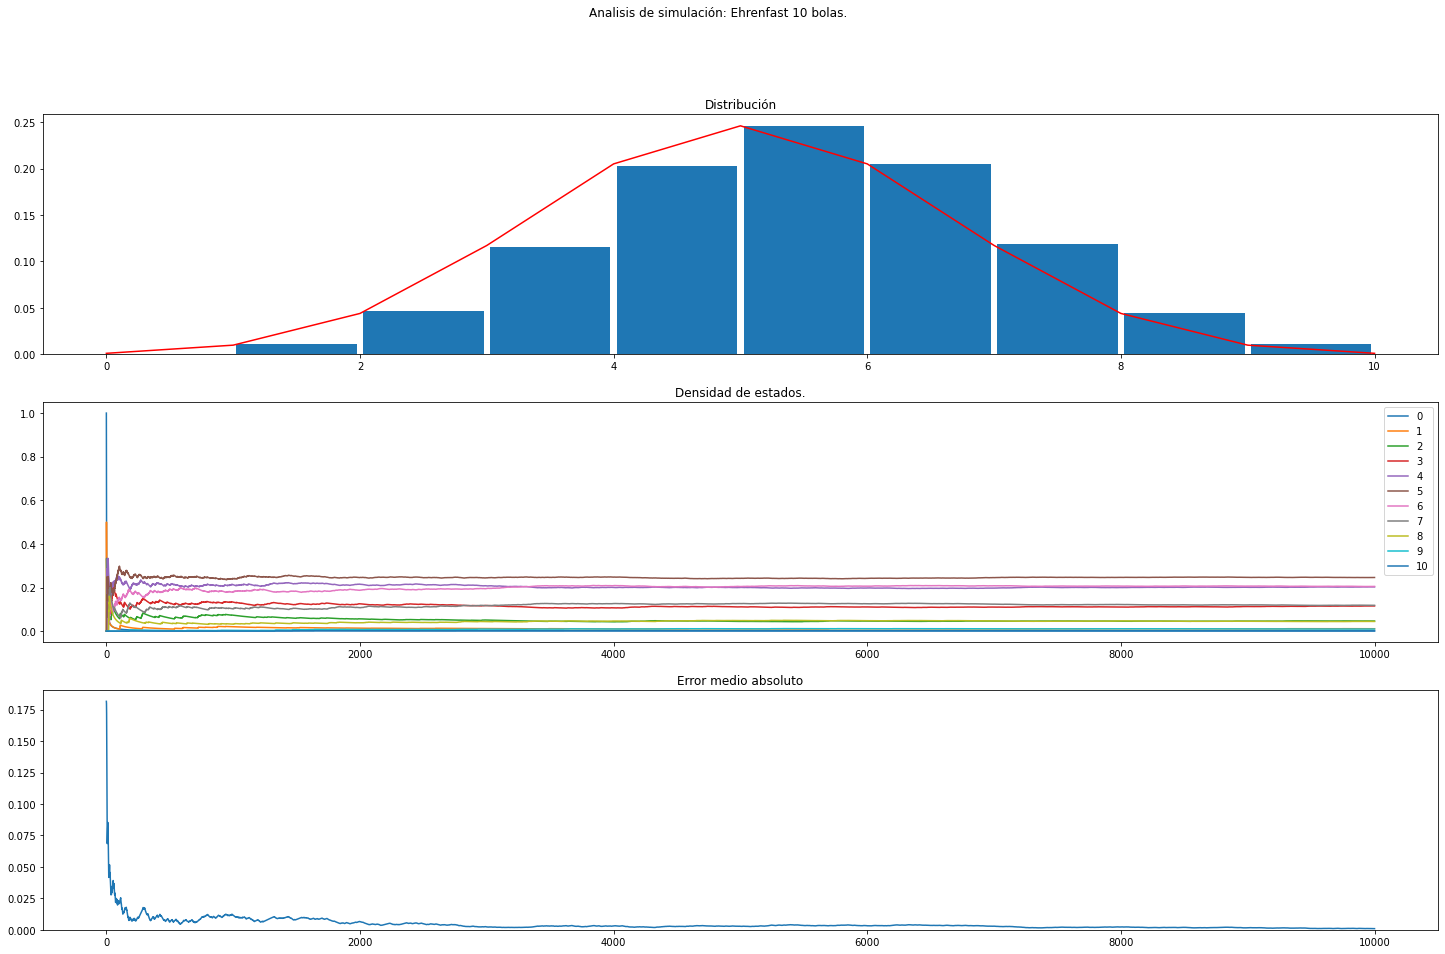

In [265]:
n = 10
n_experimentos = int(10e3)
estado_inicial = random.randint(0, n)

main(n_experimentos, estado_inicial, n)

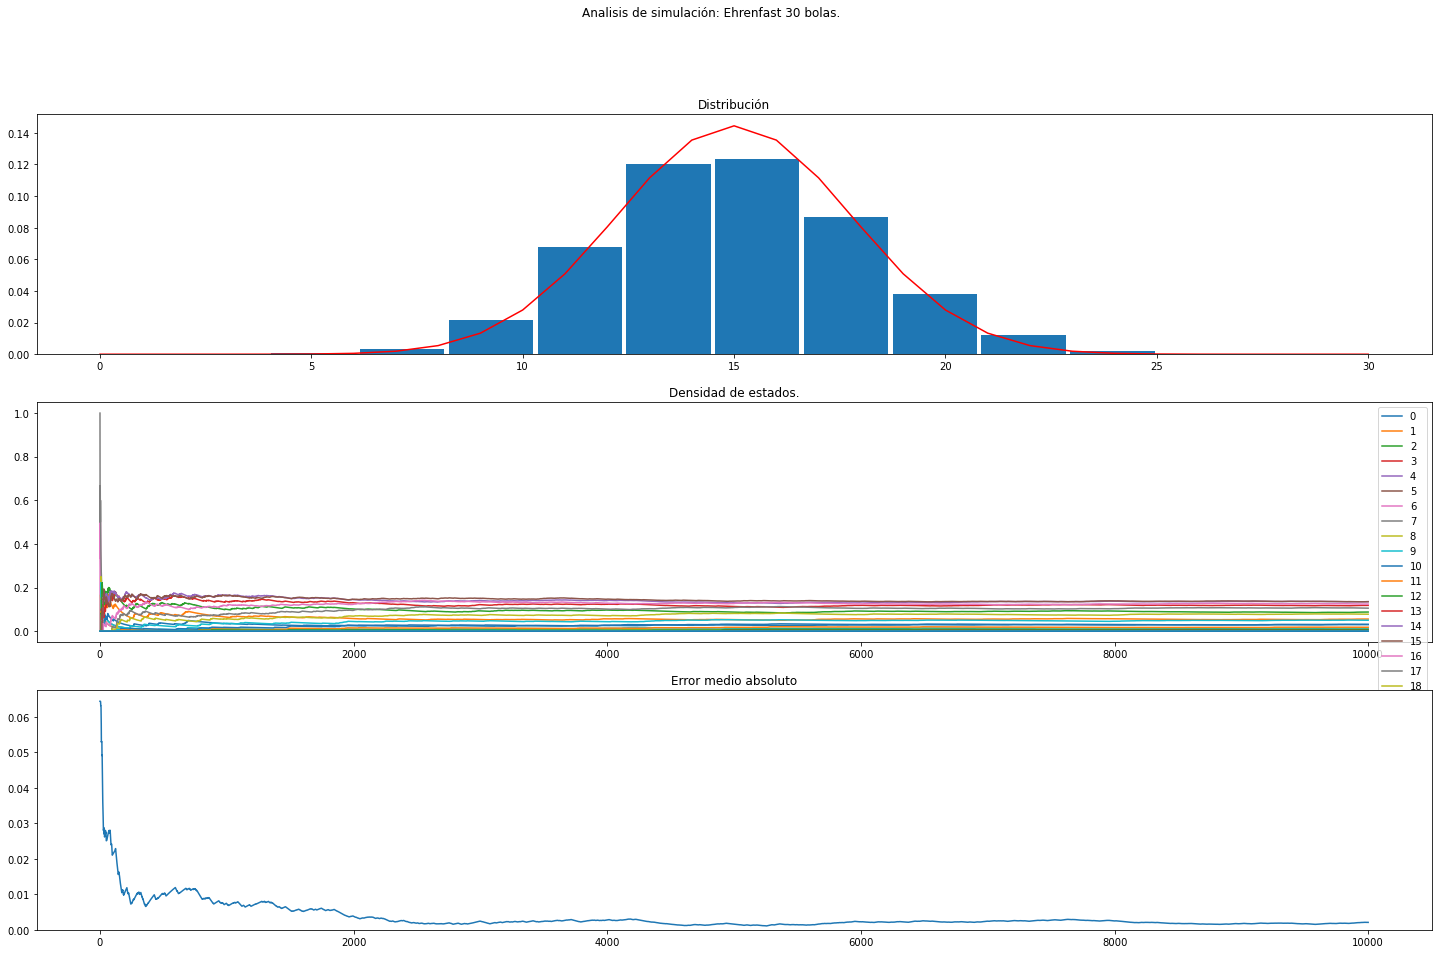

In [266]:
n = 30
n_experimentos = int(10e3)
estado_inicial = random.randint(0, n)

main(n_experimentos, estado_inicial, n)

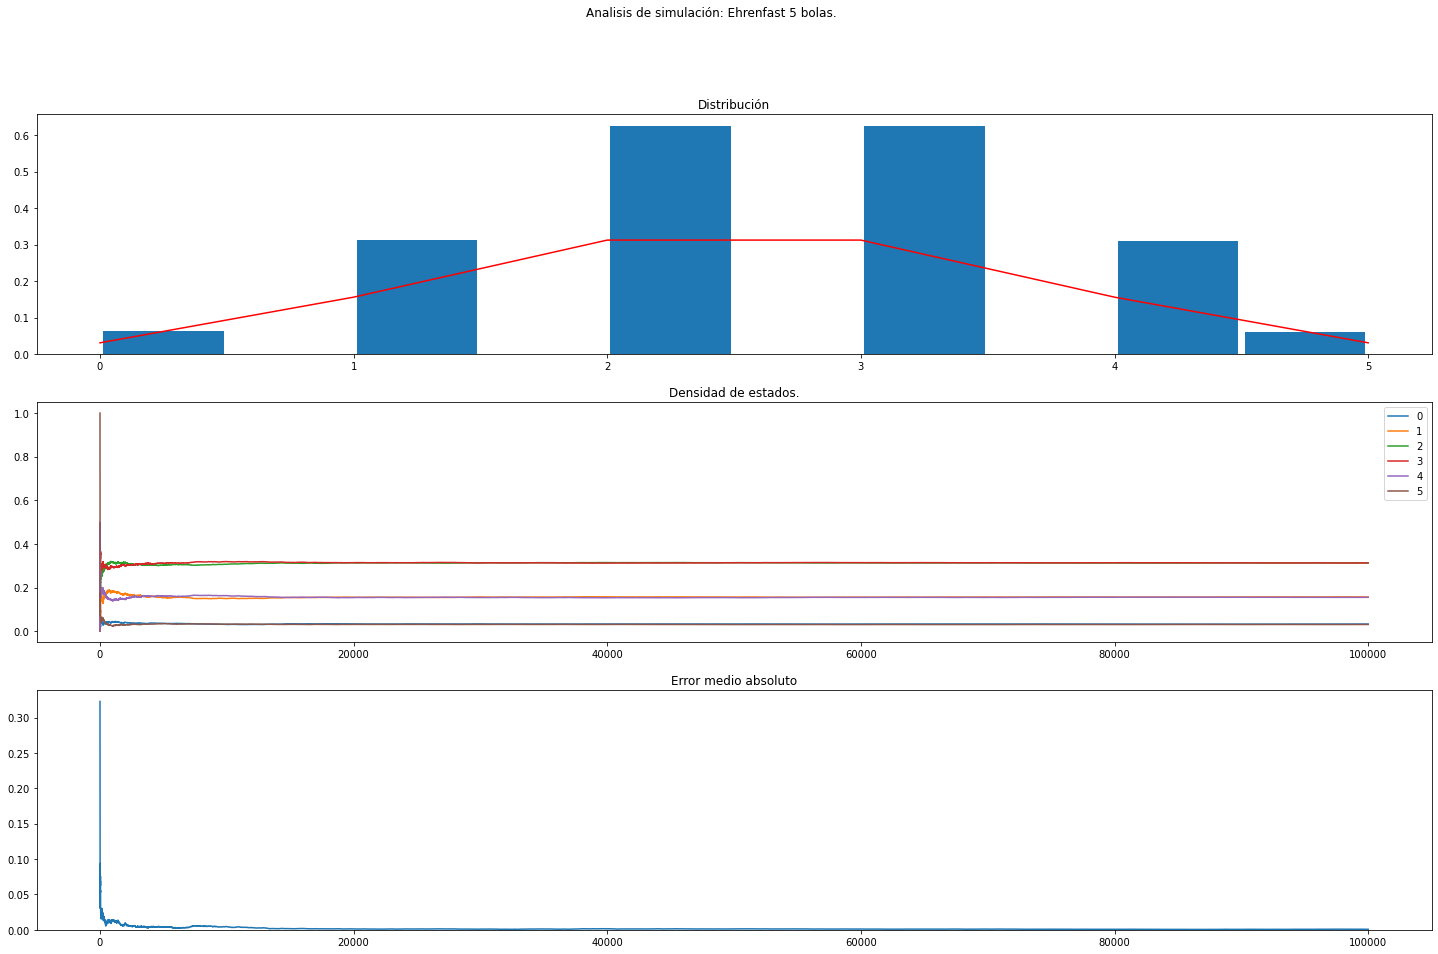

In [267]:
n = 5
n_experimentos = int(10e4)
estado_inicial = random.randint(0, n)

main(n_experimentos, estado_inicial, n)